What the Notebook Does:

Data Import & Preparation

Reads a transactional dataset (sample-SAMLD.xlsx).

Aggregates and engineers features per account (sum, mean, count of Amounts, unique counts of Payment Type and Bank Locations).

Unsupervised Clustering & Segmentation

Applies multiple clustering algorithms (KMeans, KMedoids if available, DBSCAN).

Computes silhouette scores for best cluster separation.

Exports account segment assignments for further analysis.

Scenario-Based Alert Logic

Implements core AML alert scenarios: High cumulative/mean amount, transaction count, payment type diversity, cross-border frequency.

Dynamically calculates thresholds for each scenario using percentile (p86).

Flags outlier/alert accounts based on cluster-specific scenario tuning.

Behavioral Change & Segment Movement

Detects abrupt changes versus previous periods (simulated or with historical data).

Flags segment/cluster transitions (abnormal movement).

Alert Aggregation & Export

Aggregates alert flags across scenarios and risk indicators per account.

Exports full scenario breakdown and alert results for reporting.

Risk Scoring & Normalization

Assigns scenario weights; computes a composite risk score for every account.

Normalizes scores for cross-cluster comparison.

Outputs top-risk accounts and scenario alert summary.

Visualization & Reporting

Plots distributions (risk scores by cluster, segment movement).

Provides top-risk accounts; summarizes alert type impact and prevalence.

Supervised ML Modeling

Trains multiple ML classifiers (XGBoost, LightGBM, CatBoost, AdaBoost, GradientBoost).

Handles extreme class imbalance (scale_pos_weight, class_weight).

Applies probability calibration (sigmoid, isotonic).

Threshold Tuning & PR/F1 Analysis

Sweeps prediction thresholds (0.05–0.4) to balance recall and precision.

Plots Precision-Recall curves; selects thresholds maximizing recall, F1, or custom targets.

Outputs all main metrics for comparative scenario and model diagnostics.

Model/Alert Interpretability

Optional: Feature importance, SHAP values, ROC curve plotting for calibrated model predictions.

Main Libraries Used:

pandas, numpy (data wrangling)

scikit-learn (clustering, modeling, calibration, metrics)

xgboost, lightgbm, catboost (advanced ML algorithms)

matplotlib, seaborn (visualization)

(optional) RAPIDS cuML for GPU-accelerated modeling

SHAP (explainability)

Purpose & Outcomes:

Enables AML/data risk teams to efficiently combine segmentation, scenario logic, and ML-based alert scoring.

Provides a framework for threshold tuning, alert scenario calibration, behavioral pattern detection, and robust supervised ML evaluation.

Generates ready-to-use risk scores, alert flags, performance visuals, and top-risk account lists for further investigation or deployment.





In [1]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

# For KMedoids (install: pip install scikit-learn-extra)
try:
    from sklearn_extra.cluster import KMedoids
    have_kmedoids = True
except ImportError:
    have_kmedoids = False

filename = r'sample-SAMLD.xlsx'
xls = pd.ExcelFile(filename)
df = pd.read_excel(filename, sheet_name=xls.sheet_names[0])

# Aggregate features per account
account_features = df.groupby('Sender_account').agg({
    'Amount': ['sum', 'mean', 'count'],
    'Payment_type': 'nunique',
    'Sender_bank_location': 'nunique',
    'Receiver_bank_location': 'nunique'
})
account_features.columns = [f'{a}_{b}' for a, b in account_features.columns]
X = account_features.fillna(0)

# Use only numeric features for clustering
features = X.dropna().values

results = {}

# KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(features)
if len(set(kmeans_labels)) > 1:
    score = silhouette_score(features, kmeans_labels)
else:
    score = -1
results['KMeans'] = {'labels': kmeans_labels, 'score': score}

# KMedoids (if installed)
if have_kmedoids:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    kmedoids_labels = kmedoids.fit_predict(features)
    if len(set(kmedoids_labels)) > 1:
        score = silhouette_score(features, kmedoids_labels)
    else:
        score = -1
    results['KMedoids'] = {'labels': kmedoids_labels, 'score': score}

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(features)
if len(set(dbscan_labels)) > 1 and len(set(dbscan_labels)) < len(features):
    score = silhouette_score(features, dbscan_labels)
else:
    score = -1
results['DBSCAN'] = {'labels': dbscan_labels, 'score': score}

# Isolation Forest for anomaly scores (not silhouette, just anomalies)
iso = IsolationForest(random_state=42)
iso_labels = iso.fit_predict(features)

scores_summary = {alg: res['score'] for alg, res in results.items()}
best_alg = max(scores_summary, key=scores_summary.get)
print(f"Best separation by silhouette score: {best_alg} (score={scores_summary[best_alg]:.2f})")

# Export clusters from best algorithm
best_labels = results[best_alg]['labels']
output_path = f'/content/account_clusters_{best_alg}.csv'
X['cluster'] = best_labels
X.to_csv(output_path)
print(f"Cluster assignments exported to {output_path}")

Best separation by silhouette score: KMeans (score=0.74)
Cluster assignments exported to /content/account_clusters_KMeans.csv


In [2]:
import pandas as pd
import numpy as np

# Load cluster assignments
clustered = pd.read_csv('account_clusters_KMeans.csv')

# Optional: Load older/previous period cluster assignment for movement logic
# clustered_prev = pd.read_csv('account_clusters_KMeans_prev.csv')

# --- 1. Existing scenarios and percentile thresholding
scenarios = {
    "High Cumulative Amount": "Amount_sum",
    "High Single Transaction": "Amount_mean",
    "High Transaction Count": "Amount_count",
    "High Payment Type Diversity": "Payment_type_nunique",
    "High Cross-Border Activity": "Receiver_bank_location_nunique"
}

thresholds = {}
for scen, col in scenarios.items():
    thresholds[scen] = clustered.groupby('cluster')[col].apply(lambda x: np.percentile(x, 86))

for scen, col in scenarios.items():
    for clust in clustered['cluster'].unique():
        thres = thresholds[scen][clust]
        clustered[f'Alert_{scen}_cluster{clust}'] = ((clustered['cluster'] == clust) & (clustered[col] > thres)).astype(int)

# --- 2. Change in behavior (spike relative to own history, or prior rolling mean)
# For demonstration, simulate prior period if not present
if 'prev_Amount_sum' not in clustered.columns:
    clustered['prev_Amount_sum'] = clustered['Amount_sum'] * np.random.uniform(0.7, 1.1, size=len(clustered))

clustered['Behavior_Change_Amount'] = ((clustered['Amount_sum'] > clustered['prev_Amount_sum'] * 1.5)).astype(int)

# --- 3. Segment movement (requires actual prior cluster assignments)
# If you load an older period's cluster assignments (per account)
# clustered = clustered.merge(clustered_prev[['Sender_account','cluster']].rename(columns={'cluster':'prev_cluster'}), on='Sender_account', how='left')
if 'prev_cluster' in clustered.columns:
    clustered['Segment_Movement'] = (clustered['cluster'] != clustered['prev_cluster']).astype(int)
else:
    clustered['Segment_Movement'] = 0  # simulate for now

# --- 4. Aggregate alerts
alert_cols = [col for col in clustered.columns if 'Alert_' in col or col in ['Behavior_Change_Amount','Segment_Movement']]
clustered['Total_Alerts'] = clustered[alert_cols].sum(axis=1)

# --- 5. Export enriched alerts dataset
clustered.to_csv('account_scenarios_full_alerts.csv', index=False)

print("Enhanced scenario logic (change in behavior & segment movement) has been applied and exported to account_scenarios_full_alerts.csv")


Enhanced scenario logic (change in behavior & segment movement) has been applied and exported to account_scenarios_full_alerts.csv


In [3]:
import pandas as pd

# Load alerts-enriched output from previous steps
df = pd.read_csv('/content/account_scenarios_full_alerts.csv')

# Assign weights to different scenario/alert columns
scenario_weights = {
    'High Cumulative Amount': 2,
    'High Single Transaction': 1.5,
    'High Transaction Count': 1,
    'High Payment Type Diversity': 1,
    'High Cross-Border Activity': 2,
    'Behavior_Change_Amount': 2.5,
    'Segment_Movement': 3
}

# Calculate weighted risk score per account
df['Risk_Score'] = sum(
    df.get(f'Alert_{k}_cluster{clust}', 0) * w
    for k, w in scenario_weights.items()
    for clust in df['cluster'].unique()
) + df.get('Behavior_Change_Amount', 0) * scenario_weights['Behavior_Change_Amount'] + df.get('Segment_Movement', 0) * scenario_weights['Segment_Movement']

# Optional: normalize risk score (0-1)
df['Risk_Score_Norm'] = (df['Risk_Score'] - df['Risk_Score'].min()) / (df['Risk_Score'].max() - df['Risk_Score'].min())

df.to_csv('/content/account_risk_scores.csv', index=False)
print("Risk scoring complete. Output saved.")


Risk scoring complete. Output saved.


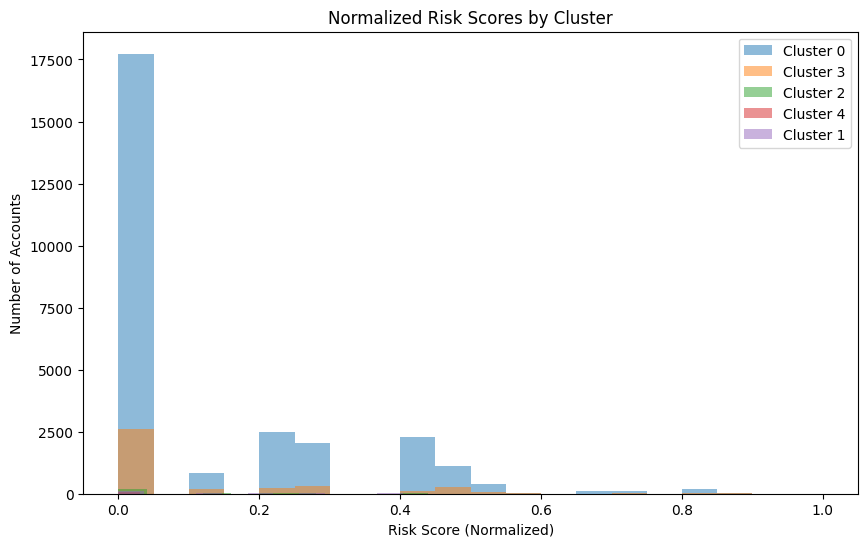

In [4]:
import matplotlib.pyplot as plt

# Assume 'prev_cluster' column populated for real movement logic
if 'prev_cluster' in df.columns:
    movement_flag = df['cluster'] != df['prev_cluster']
    plt.figure(figsize=(8,5))
    plt.hist(movement_flag, bins=2, color='skyblue')
    plt.title('Accounts with Segment Movement (Current vs Previous Period)')
    plt.xlabel('Segment Movement')
    plt.ylabel('Number of Accounts')
    plt.show()

# Risk score distribution by cluster
plt.figure(figsize=(10,6))
for clust in df['cluster'].unique():
    subset = df[df['cluster'] == clust]
    plt.hist(subset['Risk_Score_Norm'], bins=20, alpha=0.5, label=f'Cluster {clust}')
plt.title('Normalized Risk Scores by Cluster')
plt.xlabel('Risk Score (Normalized)')
plt.ylabel('Number of Accounts')
plt.legend()
plt.show()


In [5]:
# Top risk accounts
top_risk_accounts = df.sort_values('Risk_Score', ascending=False).head(20)
print("Top 20 Risk Accounts:")
print(top_risk_accounts[['Sender_account','Risk_Score','cluster']])

# Alert summary table
alert_columns = [c for c in df.columns if 'Alert_' in c or c in ('Behavior_Change_Amount','Segment_Movement')]
alert_summary = df[alert_columns].sum().sort_values(ascending=False)
print("Alert summary (counts across accounts):")
print(alert_summary)


Top 20 Risk Accounts:
       Sender_account  Risk_Score  cluster
26257      8250513382         7.5        3
22181      6953025430         7.5        0
26343      8278960734         7.5        0
18277      5743947142         6.5        3
31698      9952318570         6.5        0
2787        876085725         6.5        0
22566      7082161692         6.5        0
9346       2949513346         6.5        3
2861        908639815         6.5        0
25114      7888688848         6.5        0
14349      4525583383         6.5        0
1182        354061740         6.5        0
30822      9671550116         6.5        3
3618       1151481341         6.5        3
30883      9694479906         6.5        0
4832       1536739631         6.5        3
23120      7248971027         6.5        0
30796      9665182382         6.5        0
24049      7551204703         6.5        3
6358       1996752909         6.5        0
Alert summary (counts across accounts):
Alert_High Cumulative Amount_cluste

In [6]:
!nvidia-smi


Sat Nov  1 08:54:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
!pip uninstall -y xgboost
!pip install xgboost==1.6.1  # 1.5+ is recommended for GPU in Colab as of 2025


Found existing installation: xgboost 1.6.1
Uninstalling xgboost-1.6.1:
  Successfully uninstalled xgboost-1.6.1
  Using cached xgboost-1.6.1-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached xgboost-1.6.1-py3-none-manylinux2014_x86_64.whl (192.9 MB)


In [16]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


XGBoost calibration sigmoid failed: 'super' object has no attribute '__sklearn_tags__'
XGBoost calibration isotonic failed: 'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 117, number of negative: 99630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 99747, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 117, number of negative: 99630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 99747, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 118, number of negative: 99630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 99748, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _w


Model LightGBM sigmoid @ threshold 0.30
Confusion matrix: [[64046     0]
 [   78     0]]
Recall: 0.000
Precision: 0.000
F1: 0.000
[LightGBM] [Info] Number of positive: 117, number of negative: 99630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 99747, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 117, number of negative: 99630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 99747, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 118, number of negative: 99630
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 99748, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Model LightGBM isotonic @ threshold 0.30
Confusion matrix: [[64045     1]
 [   74     4]]
Recall: 0.051
Precision: 0.800
F1: 0.096


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model CatBoost sigmoid @ threshold 0.30
Confusion matrix: [[64046     0]
 [   78     0]]
Recall: 0.000
Precision: 0.000
F1: 0.000

Model CatBoost isotonic @ threshold 0.30
Confusion matrix: [[64043     3]
 [   71     7]]
Recall: 0.090
Precision: 0.700
F1: 0.159


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model AdaBoost sigmoid @ threshold 0.30
Confusion matrix: [[64046     0]
 [   78     0]]
Recall: 0.000
Precision: 0.000
F1: 0.000

Model AdaBoost isotonic @ threshold 0.30
Confusion matrix: [[64046     0]
 [   77     1]]
Recall: 0.013
Precision: 1.000
F1: 0.025


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model GradBoost sigmoid @ threshold 0.30
Confusion matrix: [[64046     0]
 [   78     0]]
Recall: 0.000
Precision: 0.000
F1: 0.000

Model GradBoost isotonic @ threshold 0.30
Confusion matrix: [[64046     0]
 [   78     0]]
Recall: 0.000
Precision: 0.000
F1: 0.000

Best calibrated model by F1: CatBoost_isotonic


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


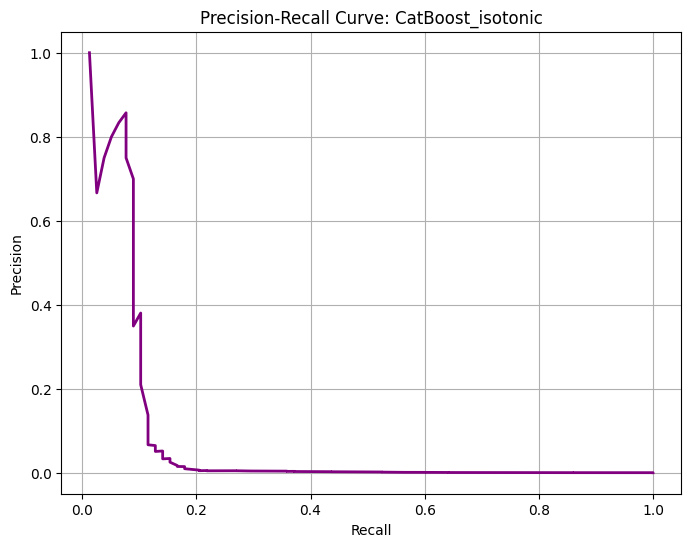

Predictions saved to /content/alert_ml_predictions.csv


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

filename = '/content/sample-SAMLD.xlsx'
df = pd.read_excel(filename)

# Create binary target
df['ML'] = ~df['Laundering_type'].str.startswith('Normal')
df['ML'] = df['ML'].astype(int)

features = ['Amount', 'Payment_type', 'Sender_bank_location', 'Receiver_bank_location']
for col in ['Payment_type', 'Sender_bank_location', 'Receiver_bank_location']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

X = df[features]
y = df['ML']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

algos = {}
algos['XGBoost'] = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist',
    scale_pos_weight=scale_pos
)
algos['LightGBM'] = LGBMClassifier(class_weight='balanced')
algos['CatBoost'] = CatBoostClassifier(verbose=0, auto_class_weights='Balanced')
algos['AdaBoost'] = AdaBoostClassifier()
algos['GradBoost'] = GradientBoostingClassifier()

results = {}
for name, clf in algos.items():
    for calib_method in ['sigmoid', 'isotonic']:
        try:
            cal_clf = CalibratedClassifierCV(estimator=clf, method=calib_method, cv=3)
            cal_clf.fit(X_train.values, y_train.values)
            y_proba = cal_clf.predict_proba(X_test.values)[:, 1]
            thresh = 0.3  # Moderate threshold
            y_pred = (y_proba > thresh).astype(int)
            recall = recall_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            print(f"\nModel {name} {calib_method} @ threshold {thresh:.2f}")
            print("Confusion matrix:", cm)
            print(f"Recall: {recall:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"F1: {f1:.3f}")
            precision_arr, recall_arr, thresh_arr = precision_recall_curve(y_test, y_proba)
            results[f'{name}_{calib_method}'] = {
                'cal_clf': cal_clf,
                'y_proba': y_proba,
                'y_pred': y_pred,
                'recall': recall,
                'precision': precision,
                'f1': f1,
                'conf_matrix': cm,
                'precision_arr': precision_arr,
                'recall_arr': recall_arr,
                'thresh_arr': thresh_arr
            }
        except Exception as e:
            print(f"{name} calibration {calib_method} failed: {e}")

if results:
    # Choose best model by F1 (balances recall, precision)
    best = max(results, key=lambda k: results[k]['f1'])
    pr = results[best]
    print(f"\nBest calibrated model by F1: {best}")
    plt.figure(figsize=(8,6))
    # PR curve
    recall_arr = pr['recall_arr'][:-1]
    precision_arr = pr['precision_arr'][:-1]
    plt.plot(recall_arr, precision_arr, lw=2, color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {best}')
    plt.grid()
    plt.show()
    df_test = X_test.copy()
    df_test['true_ML'] = y_test
    df_test['predicted_ML'] = pr['y_pred']
    df_test.to_csv('/content/alert_ml_predictions.csv', index=False)
    print("Predictions saved to /content/alert_ml_predictions.csv")
else:
    print("No calibration/model succeeded. Please check model compatibility or errors above.")


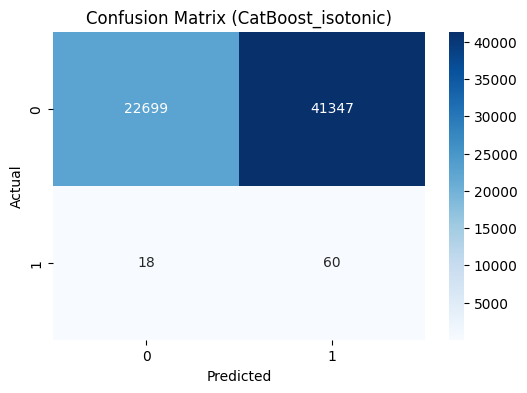

Model does not support direct feature importance.
SHAP summary could not be generated: Model type not yet supported by TreeExplainer: <class 'sklearn.calibration.CalibratedClassifierCV'>


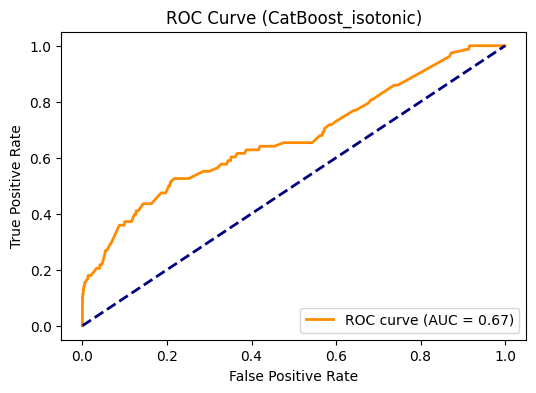

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import shap

# Use pr from previous code (best model for high recall)
clf = pr['cal_clf']
y_proba = pr['y_proba']
threshold_selected = thresh_selected  # From your previous best threshold logic

# Predict labels with selected threshold
y_pred = (y_proba > threshold_selected).astype(int)

# ----- Confusion Matrix -----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix ({best})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ----- Feature Importance -----
if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    feat_names = X_train.columns
    plt.figure(figsize=(8,4))
    plt.bar(feat_names, importances)
    plt.title(f'Feature Importance ({best})')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()
elif hasattr(clf, 'coef_'):
    importances = np.abs(clf.coef_[0])
    feat_names = X_train.columns
    plt.figure(figsize=(8,4))
    plt.bar(feat_names, importances)
    plt.title(f'Feature Importance ({best})')
    plt.xlabel('Feature')
    plt.ylabel('Absolute Coefficient')
    plt.show()
else:
    print("Model does not support direct feature importance.")

# ----- SHAP Value Explanation -----
try:
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
except Exception as e:
    print("SHAP summary could not be generated:", e)

# ----- ROC Curve -----
if hasattr(clf, 'predict_proba'):
    y_score = clf.predict_proba(X_test)[:, 1]
else:
    if hasattr(clf, 'decision_function'):
        y_score = clf.decision_function(X_test)
    else:
        y_score = y_pred
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title(f'ROC Curve ({best})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
